<a href="https://colab.research.google.com/github/EverHernandez01/Teoria_de_se-ales/blob/main/Taller/1_Quiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis Temporal y Espectral de Procesos Estocásticos

## Objetivo

Comparar el comportamiento temporal, correlacional y espectral de tres procesos:

- ARMA(3,3)
- Ruido blanco filtrado (LPF)
- Random Walk

---

## Análisis Realizado

Para cada señal se estudian:

1. Señal en el tiempo $x(t)$
2. Autocorrelación normalizada $R(\tau)$
3. Densidad Espectral de Potencia (PSD) usando Welch

---

## Autocorrelación

Se calcula:

$$
R(\tau) = \sum_n x[n]x[n+\tau]
$$

Y se normaliza:

$$
R(0) = 1
$$

Esto permite comparar la estructura de memoria de cada proceso.

---

## PSD (Welch)

Se estima la densidad espectral:

$$
S_x(f)
$$

Luego se convierte a decibeles:

$$
PSD_{dB} = 10 \log_{10}(PSD)
$$

Se limita a -30 dB para mejorar la visualización.

---

## Procesos Analizados

### 1) ARMA(3,3)

Modelo:

$$
x[n] - 0.75x[n-1] + 0.5x[n-2] - 0.3x[n-3]
=
w[n] + 0.6w[n-1] - 0.4w[n-2] + 0.25w[n-3]
$$

- Proceso estacionario
- Memoria finita
- PSD con estructura racional
- ACF con decaimiento exponencial

---

### 2) Ruido Blanco + Filtro Pasa-Bajas

- Ruido blanco filtrado por un LPF de orden 4
- Energía concentrada en bajas frecuencias
- Mayor correlación temporal

---

### 3) Random Walk

Modelo:

$$
x[n] = x[n-1] + w[n]
$$

Equivalente a:

$$
x[n] = \sum_{k=0}^{n} w[k]
$$

- Proceso no estacionario
- Energía dominante en bajas frecuencias
- ACF con decaimiento lento

---

## Conclusión

El análisis muestra cómo la estructura del sistema generador afecta:

- La forma temporal de la señal
- Su memoria estadística
- La distribución espectral de energía

Los procesos estacionarios presentan PSD bien definida y ACF decreciente, mientras que el Random Walk exhibe fuerte concentración espectral en bajas frecuencias y comportamiento no estacionario.

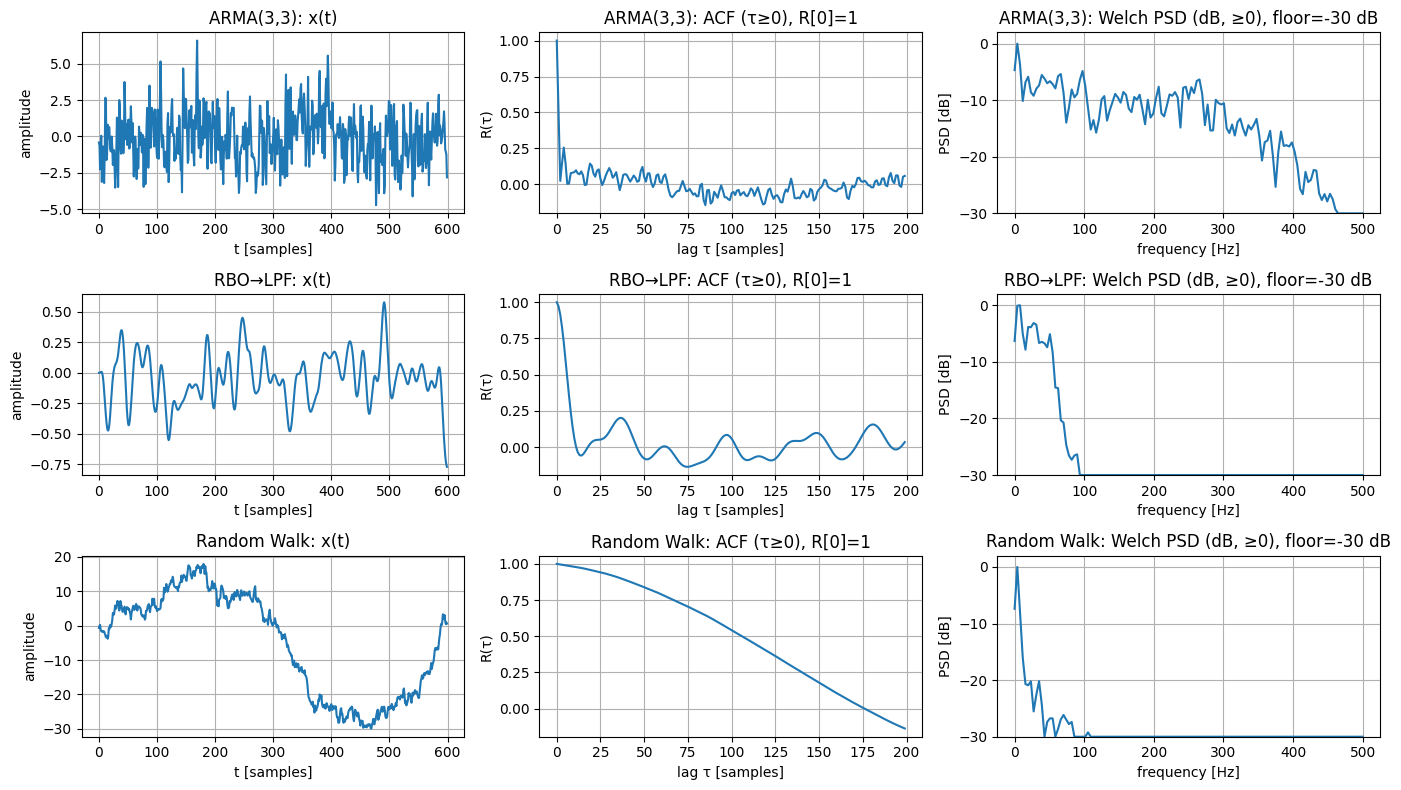

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# =====================================================
# CONFIGURACION
# =====================================================

np.random.seed(2)

N = 600
fs = 1000  # Hz
t = np.arange(N)

# =====================================================
# FUNCIONES
# =====================================================

def acf_normalizada(x, maxlags=200):

    r = np.correlate(x, x, mode='full')
    mid = len(r)//2

    r = r[mid:mid+maxlags]

    # normalizar
    r = r / r[0]

    return r


def welch_psd_db(x, fs):

    f, Pxx = signal.welch(x, fs=fs, nperseg=256)

    # normalizar
    Pxx = Pxx / np.max(Pxx)

    # convertir a dB
    Pxx_db = 10*np.log10(Pxx)

    # limitar a -30 dB
    Pxx_db[Pxx_db < -30] = -30

    return f, Pxx_db


# =====================================================
# GENERACION DE SEÑALES
# =====================================================

# ARMA(3,3)
ar = [1, -0.75, 0.5, -0.3]
ma = [1, 0.6, -0.4, 0.25]

arma33 = signal.lfilter(ma, ar, np.random.randn(N))


# Ruido blanco + LPF
noise = np.random.randn(N)

b, a = signal.butter(4, 0.08)

lpf_signal = signal.lfilter(b, a, noise)


# Random walk
rw = np.cumsum(np.random.randn(N))


# SOLO 3 SEÑALES (AR(3) ELIMINADA)
signals = [arma33, lpf_signal, rw]

titles = [
    "ARMA(3,3)",
    "RBO→LPF",
    "Random Walk"
]


# =====================================================
# GRAFICA 3x3
# =====================================================

fig, axes = plt.subplots(3, 3, figsize=(14, 8))

for i in range(3):

    x = signals[i]

    # x(t)
    axes[i,0].plot(t, x)
    axes[i,0].set_title(f"{titles[i]}: x(t)")
    axes[i,0].set_xlabel("t [samples]")
    axes[i,0].set_ylabel("amplitude")
    axes[i,0].grid(True)


    # ACF
    r = acf_normalizada(x)

    axes[i,1].plot(r)
    axes[i,1].set_title(f"{titles[i]}: ACF (τ≥0), R[0]=1")
    axes[i,1].set_xlabel("lag τ [samples]")
    axes[i,1].set_ylabel("R(τ)")
    axes[i,1].grid(True)


    # PSD
    f, psd = welch_psd_db(x, fs)

    axes[i,2].plot(f, psd)
    axes[i,2].set_title(f"{titles[i]}: Welch PSD (dB, ≥0), floor=-30 dB")
    axes[i,2].set_xlabel("frequency [Hz]")
    axes[i,2].set_ylabel("PSD [dB]")
    axes[i,2].set_ylim([-30, 2])
    axes[i,2].grid(True)


plt.tight_layout()
plt.show()

In [ ]:
# =====================================================
# PRUEBA DE ESTACIONARIEDAD USANDO PSD
# =====================================================

def prueba_estacionariedad_psd(x, fs):

    f, Pxx = signal.welch(x, fs=fs, nperseg=256)

    # normalizar
    Pxx = Pxx / np.max(Pxx)

    # energia en baja frecuencia
    low_freq_power = np.mean(Pxx[0:5])

    # energia en media frecuencia
    mid_freq_power = np.mean(Pxx[len(Pxx)//4:len(Pxx)//2])

    ratio = low_freq_power / mid_freq_power

    # criterio empirico
    if ratio > 5:
        return False, ratio
    else:
        return True, ratio


# =====================================================
# EVALUAR TODAS LAS SEÑALES
# =====================================================

print("\n====================================")
print("PRUEBA DE ESTACIONARIEDAD (usando PSD)")
print("====================================\n")

for i in range(len(signals)):

    estacionario, ratio = prueba_estacionariedad_psd(signals[i], fs)

    print(titles[i])

    if estacionario:
        print("Resultado: ESTACIONARIO")
    else:
        print("Resultado: NO ESTACIONARIO")

    print("ratio baja/media frecuencia =", round(ratio,3))
    print("")


PRUEBA DE ESTACIONARIEDAD (usando PSD)

ARMA(3,3)
Resultado: ESTACIONARIO
ratio baja/media frecuencia = 4.209

RBO→LPF
Resultado: NO ESTACIONARIO
ratio baja/media frecuencia = 35996.791

Random Walk
Resultado: NO ESTACIONARIO
ratio baja/media frecuencia = 1234.382



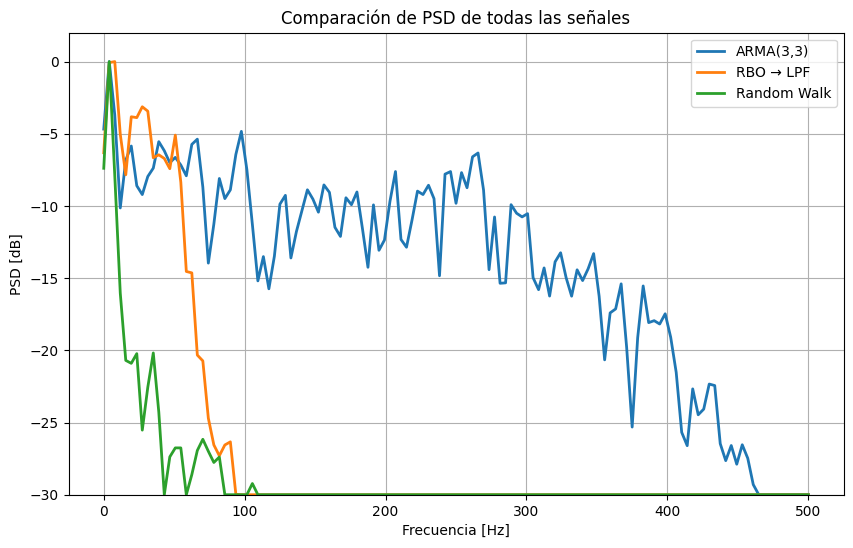

In [ ]:
# =====================================================
# GRAFICA COMPARATIVA DE TODOS LOS PSD
# =====================================================

plt.figure(figsize=(10,6))

for i in range(3):

    x = signals[i]

    f, psd = welch_psd_db(x, fs)

    plt.plot(f, psd, linewidth=2, label=titles[i])


plt.title("Comparación de PSD de todas las señales")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD [dB]")

plt.ylim([-30, 2])

plt.grid(True)

plt.legend()

plt.show()

# Modelado Paramétrico de la Autocorrelación mediante Suma Gaussiana

## Objetivo

Determinar el número mínimo de funciones gaussianas necesarias para aproximar la función de autocorrelación (ACF) de distintos procesos estocásticos.

---

## Modelo Matemático

Se aproxima la autocorrelación como:

$$
R(\tau) \approx \sum_{k=1}^{K} \omega_k e^{-\alpha_k \tau^2}
$$

con restricciones:

$$
\alpha_k > 0, \quad \omega_k > 0
$$

Cada término gaussiano es positivo definido, por lo que la suma también lo es.

---

## Criterio de Optimización

Se minimiza el error cuadrático medio:

$$
\text{MSE} = \frac{1}{T} \sum_{\tau} \left(R_{\text{real}}(\tau) - R_{\text{modelo}}(\tau)\right)^2
$$

También se evalúa la norma L2:

$$
\|R_{\text{real}} - R_{\text{modelo}}\|_2
$$

El algoritmo busca el valor mínimo de $K$ tal que:

$$
\text{MSE} < \epsilon \quad \text{y} \quad \| \cdot \|_2 < \epsilon
$$

---

## Procesos Analizados

- ARMA(3,3)
- Ruido blanco filtrado por un filtro pasa-bajas
- Random Walk

---

## Interpretación

- Un valor pequeño de $K$ indica una estructura de correlación simple.
- Un valor grande de $K$ indica mayor complejidad temporal.
- El Random Walk suele requerir más gaussianas debido a su lenta decadencia de correlación.

---

## Conclusión

Este enfoque permite modelar la estructura temporal de procesos estocásticos usando una base positiva y físicamente consistente, determinando automáticamente la complejidad mínima necesaria para representar la autocorrelación.

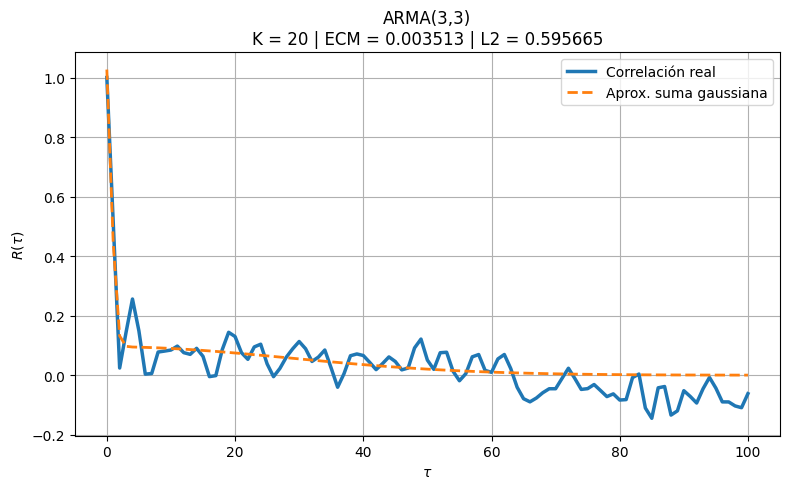

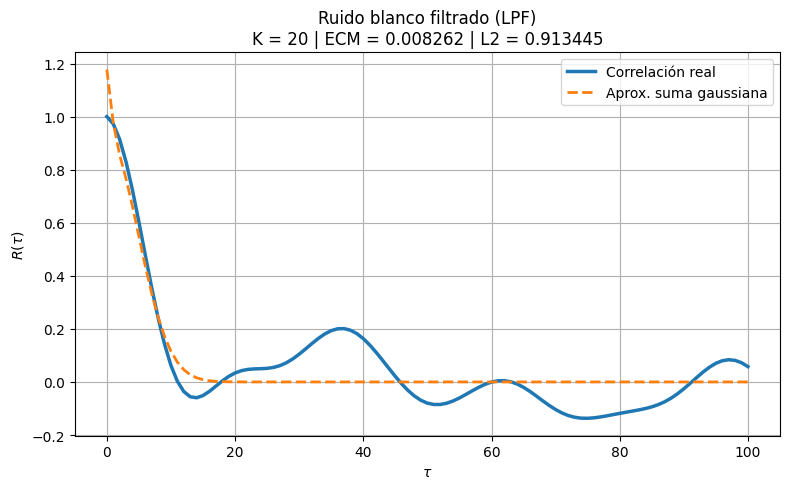


Random Walk
K mínimo = 1
ECM = 0.000035
Norma L2 = 0.059519


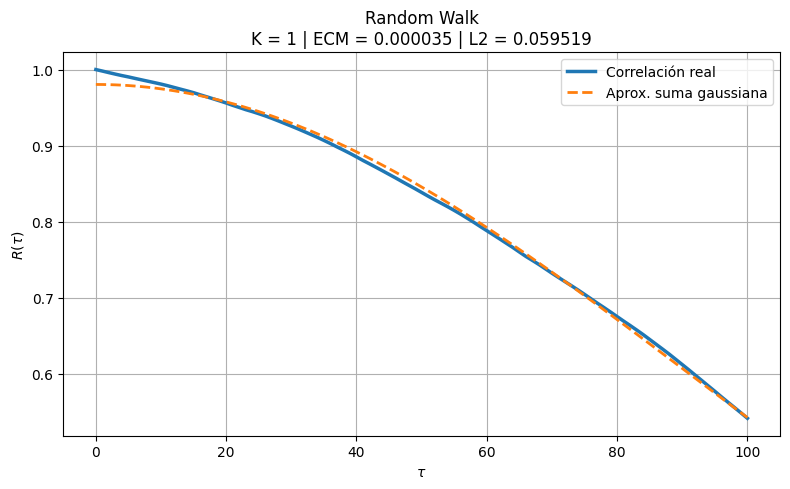

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import signal

# ==========================================================
# CONFIGURACIÓN
# ==========================================================

np.random.seed(2)
torch.manual_seed(2)

N = 600
TAU_MAX = 100
MAX_K = 20
ITERS = 2500
LR = 0.03
RESTARTS = 3
EPSILON_OBJ = 0.1

device = torch.device("cpu")

tau = torch.arange(TAU_MAX + 1).float().to(device)

# ==========================================================
# ACF NORMALIZADA
# ==========================================================

def acf_normalizada(x, maxlags=200):
    r = np.correlate(x, x, mode='full')
    mid = len(r)//2
    r = r[mid:mid+maxlags]
    return r / r[0]

# ==========================================================
# MODELO GAUSSIANO
# ==========================================================

def gaussian_sum(tau, alphas, weights):
    return torch.sum(
        weights.unsqueeze(1) *
        torch.exp(-alphas.unsqueeze(1) * tau**2),
        dim=0
    )

def mse_real(R_true, R_hat):
    return torch.mean((R_true - R_hat)**2)

def l2_norm(R_true, R_hat):
    return torch.norm(R_true - R_hat, p=2)

# ==========================================================
# AJUSTE COMPLETO (α_k y ω_k > 0)
# ==========================================================

def fit_model(R_target, K):

    best_loss = float("inf")
    best_params = None

    for r in range(RESTARTS):

        a_raw = torch.randn(K, requires_grad=True)
        w_raw = torch.randn(K, requires_grad=True)

        optimizer = torch.optim.Adam([a_raw, w_raw], lr=LR)

        for i in range(ITERS):

            optimizer.zero_grad()

            alphas = F.softplus(a_raw) + 1e-8
            weights = F.softplus(w_raw)

            R_hat = gaussian_sum(tau, alphas, weights)

            loss = mse_real(R_target, R_hat)

            loss.backward()
            optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_params = (
                F.softplus(a_raw).detach(),
                F.softplus(w_raw).detach()
            )

    return best_params[0], best_params[1], best_loss


# ==========================================================
# ANALIZAR CADA PROCESO
# ==========================================================

def analyze_process(x, title):

    r_np = acf_normalizada(x, maxlags=200)
    R_target = torch.tensor(r_np[:TAU_MAX+1]).float().to(device)

    for K in range(1, MAX_K + 1):

        alphas, weights, mse = fit_model(R_target, K)

        R_hat = gaussian_sum(tau, alphas, weights)

        l2 = l2_norm(R_target, R_hat).item()

        if mse < EPSILON_OBJ and l2 < EPSILON_OBJ:
            print(f"\n{title}")
            print(f"K mínimo = {K}")
            print(f"ECM = {mse:.6f}")
            print(f"Norma L2 = {l2:.6f}")
            break

    # ----------- Gráfica -----------

    plt.figure(figsize=(8,5))

    plt.plot(tau.numpy(),
             R_target.numpy(),
             linewidth=2.5,
             label="Correlación real")

    plt.plot(tau.numpy(),
             R_hat.detach().numpy(),
             linestyle='--',
             linewidth=2,
             label="Aprox. suma gaussiana")

    plt.xlabel(r"$\tau$")
    plt.ylabel(r"$R(\tau)$")
    plt.title(f"{title}\nK = {K} | ECM = {mse:.6f} | L2 = {l2:.6f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ==========================================================
# GENERACIÓN DE SEÑALES
# ==========================================================

# ARMA(3,3)
ar = [1, -0.75, 0.5, -0.3]
ma = [1, 0.6, -0.4, 0.25]
arma33 = signal.lfilter(ma, ar, np.random.randn(N))

# Ruido blanco + LPF
noise = np.random.randn(N)
b, a = signal.butter(4, 0.08)
lpf_signal = signal.lfilter(b, a, noise)

# Random walk
rw = np.cumsum(np.random.randn(N))


# ==========================================================
# EJECUTAR
# ==========================================================

analyze_process(arma33, "ARMA(3,3)")
analyze_process(lpf_signal, "Ruido blanco filtrado (LPF)")
analyze_process(rw, "Random Walk")

# Análisis Espectral mediante Ajuste Gaussiano de la ACF

## Objetivo

Comparar la Densidad Espectral de Potencia (PSD) empírica de diferentes procesos aleatorios con una PSD reconstruida a partir del ajuste gaussiano de su función de autocorrelación (ACF).

---

## Fundamento Teórico

### Teorema de Wiener–Khinchin

Para un proceso estacionario:

$$
S_X(\omega) = \sum_{\tau=-\infty}^{\infty} R_X(\tau)\, e^{-j\omega\tau}
$$

Es decir, la PSD es la Transformada de Fourier de la autocorrelación.

---

## Ajuste Gaussiano de la ACF

Se aproxima la autocorrelación como:

$$
R_X(\tau) \approx \sum_{k=1}^{N} \omega_k e^{-\alpha_k \tau^2}
$$

con restricciones:

$$
\omega_k \ge 0, \quad \sum_{k=1}^{N} \omega_k = 1, \quad \alpha_k > 0
$$

---

## Reconstrucción de la PSD

Aplicando nuevamente la transformada:

$$
S_X(\omega) = \mathcal{F}\{R_X(\tau)\}
$$

---

## Conclusión

Si la PSD reconstruida coincide con la PSD empírica, entonces la mezcla gaussiana modela correctamente la estructura estadística del proceso.

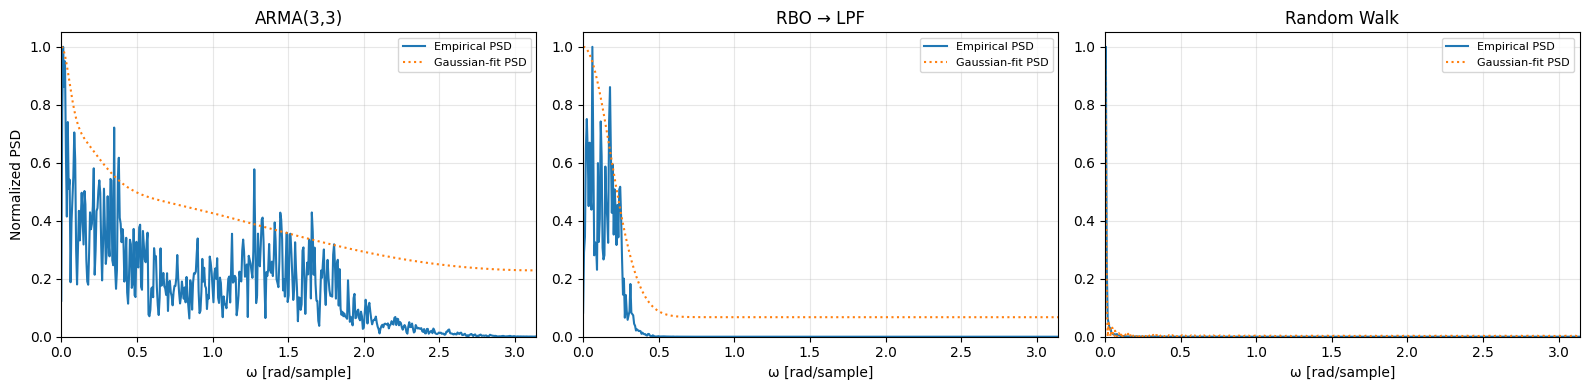

In [11]:
# ==========================================================
# COMPLETE SELF-CONTAINED VERSION (COLAB SAFE)
# ==========================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import torch

np.random.seed(2)
torch.manual_seed(2)

# ----------------------------------------------------------
# Generate signals
# ----------------------------------------------------------

N = 4000
t = np.arange(N)

ar = [1, -0.75, 0.5, -0.3]
ma = [1, 0.6, -0.4, 0.25]
arma33 = signal.lfilter(ma, ar, np.random.randn(N))

noise = np.random.randn(N)
b, a = signal.butter(4, 0.08)
lpf_signal = signal.lfilter(b, a, noise)

rw = np.cumsum(np.random.randn(N))
rw = signal.detrend(rw)

signals = {
    "ARMA(3,3)": arma33,
    "RBO → LPF": lpf_signal,
    "Random Walk": rw
}

# ----------------------------------------------------------
# ACF function
# ----------------------------------------------------------

def acf_normalized(x, maxlags=300):
    r = np.correlate(x, x, mode='full')
    mid = len(r)//2
    r = r[mid:mid+maxlags]
    return r / r[0]

# ----------------------------------------------------------
# Gaussian ACF fit (simple version)
# ----------------------------------------------------------

def fit_gaussian_acf(tau, target, N=8, steps=1500):

    tau = torch.tensor(tau, dtype=torch.float64)
    target = torch.tensor(target, dtype=torch.float64)

    tau2 = tau**2

    raw_logits = torch.nn.Parameter(torch.randn(N, dtype=torch.float64)*0.1)
    raw_alpha = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))

    opt = torch.optim.Adam([raw_logits, raw_alpha], lr=0.05)

    for _ in range(steps):
        opt.zero_grad()

        omega = torch.softmax(raw_logits, dim=0)
        alpha = torch.nn.functional.softplus(raw_alpha) + 1e-8

        basis = torch.exp(-tau2[:, None] * alpha[None, :])
        fitted = basis @ omega

        loss = torch.mean((fitted - target)**2)
        loss.backward()
        opt.step()

    with torch.no_grad():
        omega = torch.softmax(raw_logits, dim=0).numpy()
        alpha = (torch.nn.functional.softplus(raw_alpha)+1e-8).numpy()

    return omega, alpha

# ----------------------------------------------------------
# PSD from ACF via DTFT
# ----------------------------------------------------------

def psd_from_acf(tau, acf, omega):
    kernel = np.exp(-1j * omega[:, None] * tau[None, :])
    psd = np.real(kernel @ acf)
    psd = np.maximum(psd, 0)
    return psd / np.max(psd)

# ----------------------------------------------------------
# Plot comparison
# ----------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(16,4))

for i, (name, x) in enumerate(signals.items()):

    # Empirical PSD
    w_emp, P_emp = signal.welch(x, fs=2*np.pi, nperseg=1024)
    P_emp /= np.max(P_emp)

    # ACF
    tau = np.arange(0, 300)
    r = acf_normalized(x, maxlags=300)

    # Fit Gaussian mixture
    omega_g, alpha_g = fit_gaussian_acf(tau, r, N=10)

    # Reconstruct ACF
    basis = np.exp(-tau[:, None]**2 * alpha_g[None, :])
    r_fit = basis @ omega_g

    # Gaussian PSD
    P_gauss = psd_from_acf(tau, r_fit, w_emp)

    # Plot (ONLY empirical and gaussian fit)
    ax = axes[i]
    ax.plot(w_emp, P_emp, label="Empirical PSD")
    ax.plot(w_emp, P_gauss, ':', label="Gaussian-fit PSD")

    ax.set_xlim(0, np.pi)
    ax.set_ylim(0, 1.05)
    ax.set_title(name)
    ax.set_xlabel("ω [rad/sample]")
    if i == 0:
        ax.set_ylabel("Normalized PSD")

    ax.grid(alpha=0.3)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


ARMA(3,3)
Promedio de las medias: -0.009821988206822426
Promedio de las varianzas: 3.03937264919281


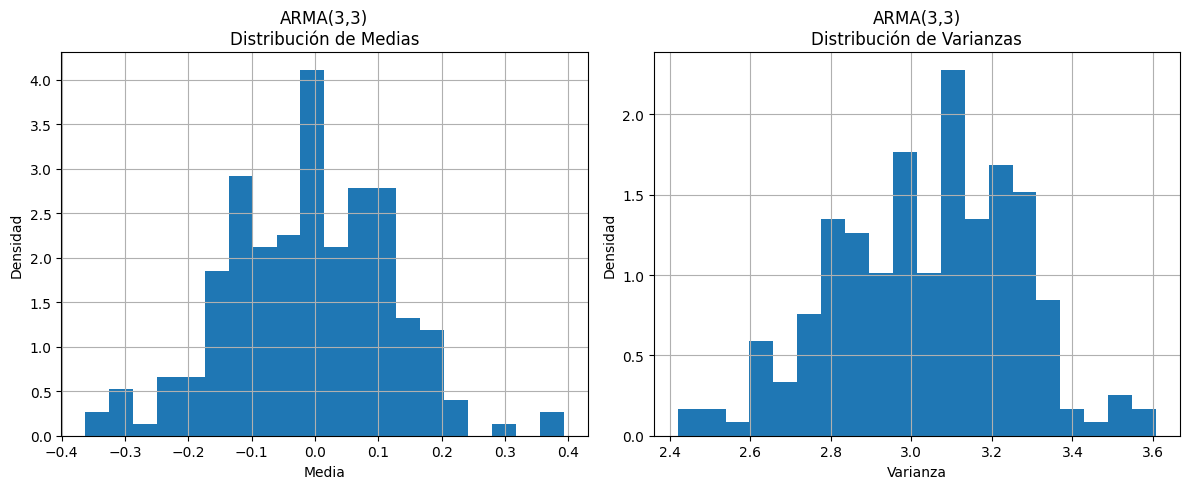


Ruido blanco filtrado (LPF)
Promedio de las medias: -0.0005077659642120125
Promedio de las varianzas: 0.07758704708889126


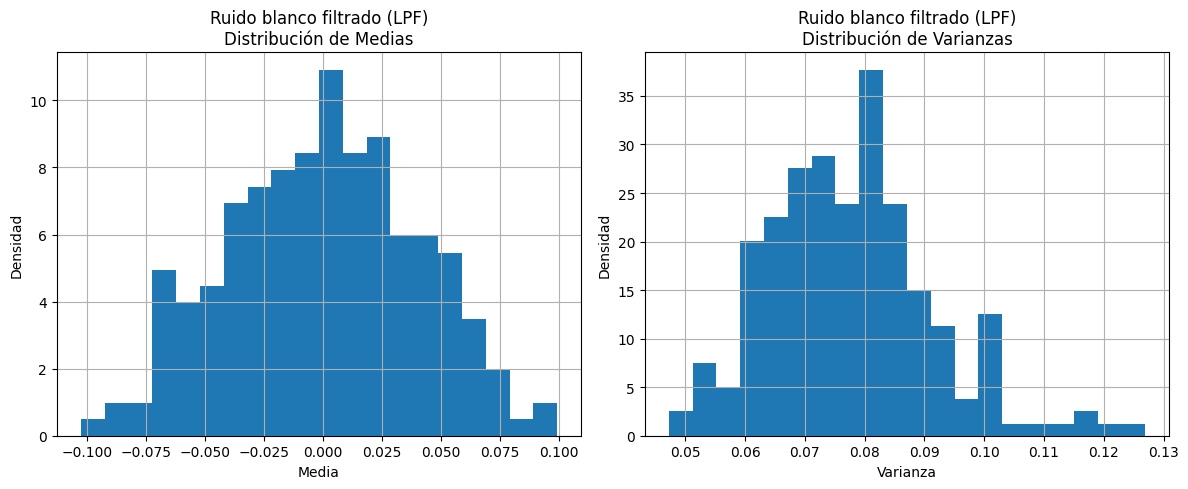


Random Walk
Promedio de las medias: -0.74086023257114
Promedio de las varianzas: 104.36375311851502


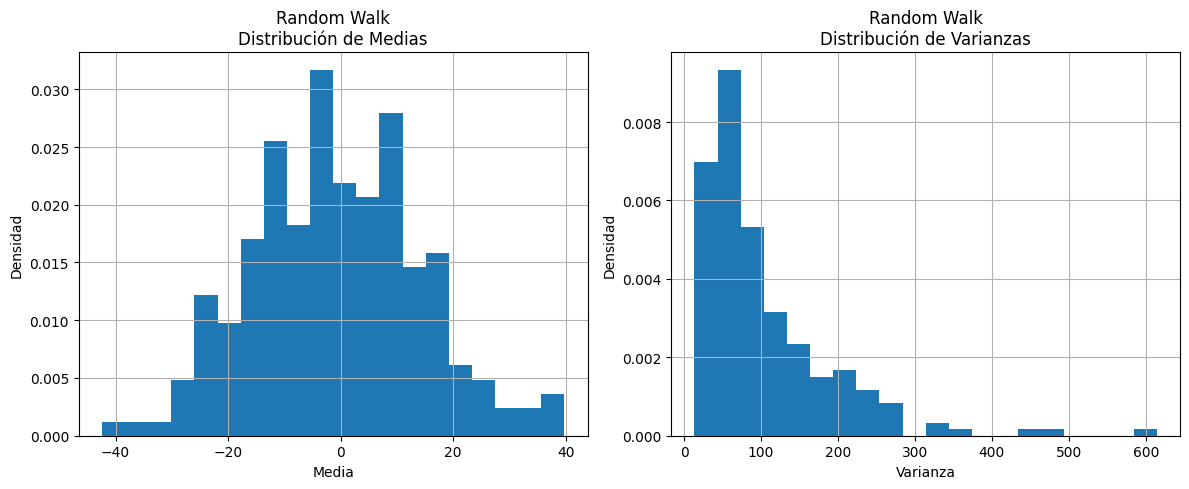

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# ==========================================================
# CONFIGURACIÓN
# ==========================================================

torch.manual_seed(2)
np.random.seed(2)

N = 600
REALIZACIONES = 200

device = torch.device("cpu")

# ==========================================================
# GENERADORES DE PROCESOS
# ==========================================================

def generate_arma33(N):
    ar = [1, -0.75, 0.5, -0.3]
    ma = [1, 0.6, -0.4, 0.25]
    return signal.lfilter(ma, ar, np.random.randn(N))

def generate_lpf(N):
    noise = np.random.randn(N)
    b, a = signal.butter(4, 0.08)
    return signal.lfilter(b, a, noise)

def generate_rw(N):
    return np.cumsum(np.random.randn(N))

# ==========================================================
# ANALISIS ESTADISTICO
# ==========================================================

def analyze_process(generator, title):

    means = []
    variances = []

    for _ in range(REALIZACIONES):

        x = torch.tensor(generator(N)).float()

        means.append(torch.mean(x).item())
        variances.append(torch.var(x, unbiased=True).item())

    means = np.array(means)
    variances = np.array(variances)

    print("\n=====================================")
    print(title)
    print("Promedio de las medias:", np.mean(means))
    print("Promedio de las varianzas:", np.mean(variances))

    # ================== GRÁFICAS ==================

    plt.figure(figsize=(12,5))

    # Histograma medias
    plt.subplot(1,2,1)
    plt.hist(means, bins=20, density=True)
    plt.title(f"{title}\nDistribución de Medias")
    plt.xlabel("Media")
    plt.ylabel("Densidad")
    plt.grid(True)

    # Histograma varianzas
    plt.subplot(1,2,2)
    plt.hist(variances, bins=20, density=True)
    plt.title(f"{title}\nDistribución de Varianzas")
    plt.xlabel("Varianza")
    plt.ylabel("Densidad")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# ==========================================================
# EJECUTAR PARA LOS 3 PROCESOS
# ==========================================================

analyze_process(generate_arma33, "ARMA(3,3)")
analyze_process(generate_lpf, "Ruido blanco filtrado (LPF)")
analyze_process(generate_rw, "Random Walk")

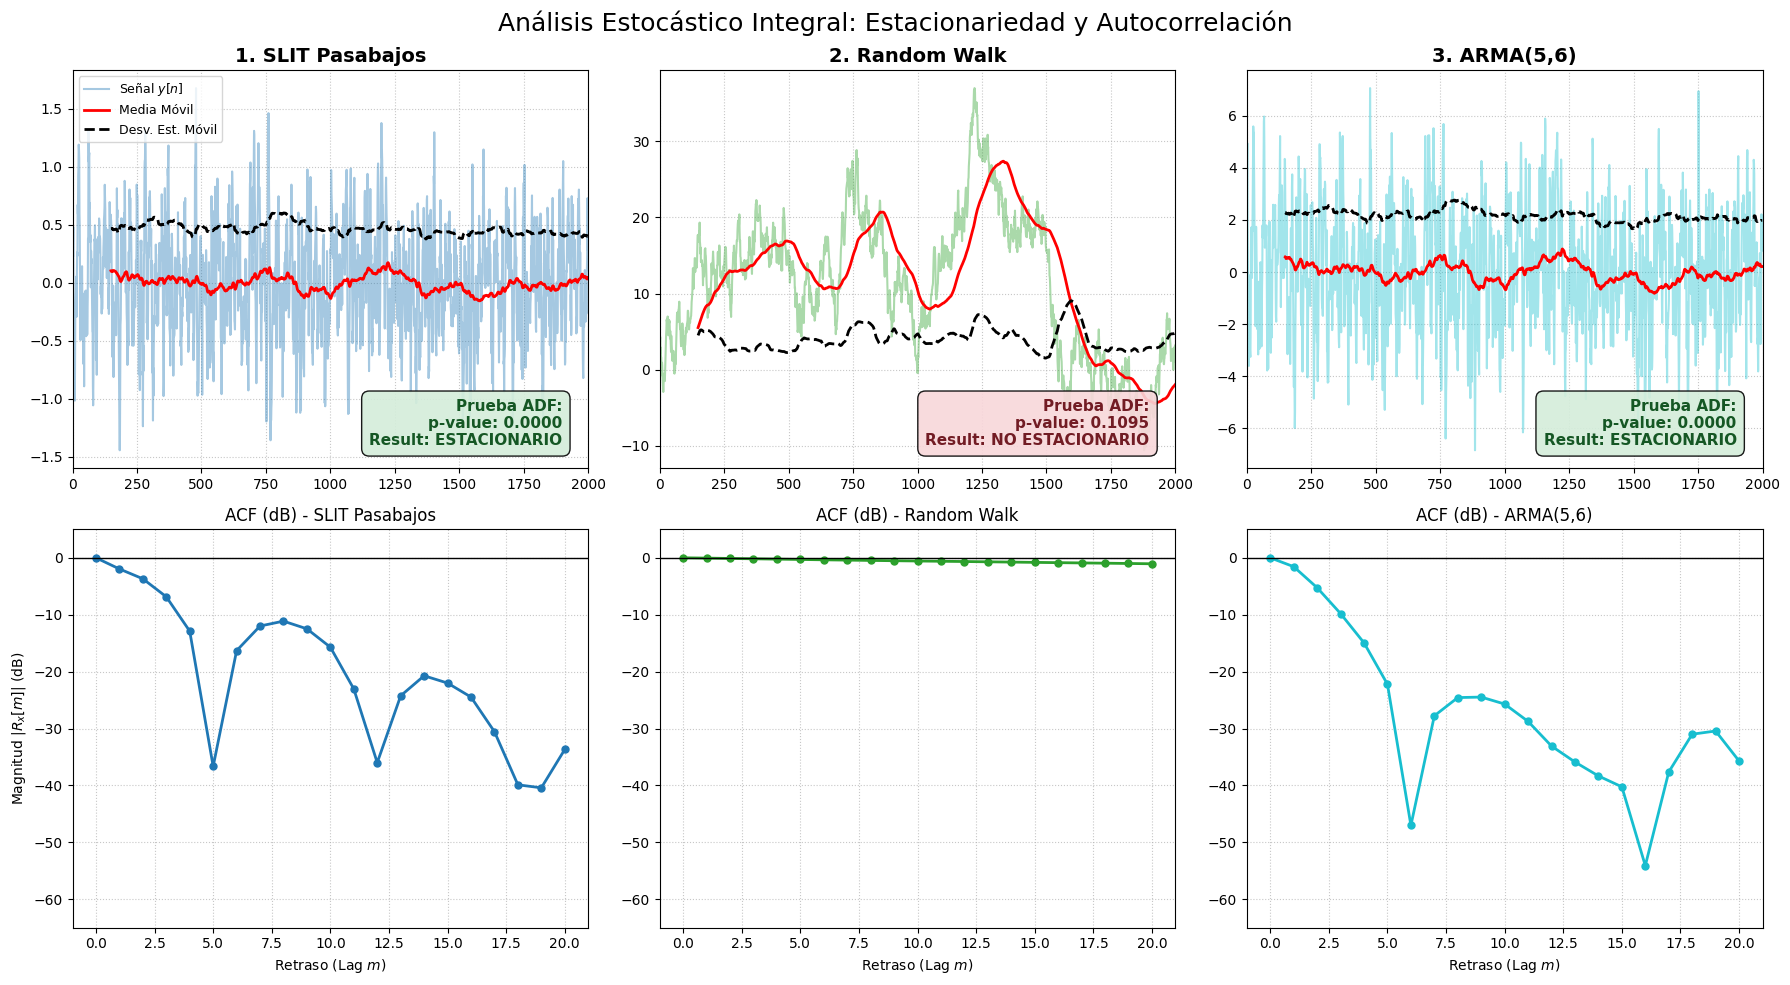

In [ ]:
import torch
import torch.nn.functional as F
import math
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings

# Ignoramos advertencias de statsmodels para mantener la salida limpia
warnings.filterwarnings("ignore")

# ==========================================
# 0. FUNCIONES BASE
# ==========================================

def lfilter_pytorch(b, a, x):
    """Implementación de filtro IIR (similar a scipy.signal.lfilter) en PyTorch"""
    y = torch.zeros_like(x)
    for n in range(len(x)):
        for i in range(len(b)):
            if n - i >= 0:
                y[n] += b[i] * x[n - i]
        for j in range(1, len(a)):
            if n - j >= 0:
                y[n] -= a[j] * y[n - j]
        y[n] /= a[0]
    return y

def acf_pytorch(x, max_lag=20):
    """Calcula la Autocorrelación usando FFT (Teorema Wiener-Khinchin)"""
    x_centered = x - torch.mean(x)
    N = len(x)
    n_fft = 2 * N - 1
    X = torch.fft.fft(x_centered, n=n_fft)
    S = torch.abs(X)**2
    R = torch.fft.ifft(S).real
    R = R / R[0]  # Normalización para que R[0] = 1
    return R[:max_lag+1]

def to_db(tensor, min_db=-60):
    """Convierte magnitud a decibelios para mejor visualización"""
    val_abs = torch.abs(tensor)
    db = 20 * torch.log10(val_abs + 1e-12)
    return torch.clamp(db, min=min_db).numpy()

def check_stationarity(y_tensor):
    """
    Ejecuta el test de Dickey-Fuller Aumentado (ADF).
    Retorna: p-value y booleano (True si es estacionario).
    """
    ts = y_tensor.numpy()
    # autolag='AIC' elige automáticamente el lag óptimo para el test
    result = adfuller(ts, autolag='AIC')
    p_value = result[1]
    is_stationary = p_value < 0.05
    return p_value, is_stationary

# ==========================================
# 1. GENERACIÓN DE SEÑALES
# ==========================================

torch.manual_seed(42)
N = 2000
w_ruido = torch.randn(N)
lags_m = torch.arange(0, 21, dtype=torch.float32)

# --- 1. SLIT Pasabajos (FIR) ---
# Señal estacionaria por definición (salida acotada de sistema estable)
M = 50
n_filt = torch.arange(M + 1).float()
fc = 0.1
sinc_arg = 2 * math.pi * fc * (n_filt - M/2)
h = torch.sin(sinc_arg) / sinc_arg
h[M//2] = 2 * fc
h = h * (0.54 - 0.46 * torch.cos(2 * math.pi * n_filt / M)) # Ventana Hamming
h = h / torch.sum(h)

y_fir = F.conv1d(w_ruido.view(1, 1, -1), h.view(1, 1, -1), padding=M//2).squeeze()
R_slit = acf_pytorch(y_fir, max_lag=20)

# --- 2. Random Walk ---
# Señal NO estacionaria (integral de ruido blanco, varianza crece con t)
y_rw = torch.cumsum(w_ruido, dim=0)
R_rw = acf_pytorch(y_rw, max_lag=20)

# --- 3. ARMA(5,6) ---
# Generalmente estacionaria si los polos están dentro del círculo unitario
b_arma = torch.tensor([1.0, 0.6, 0.4, 0.2, 0.1, 0.05, 0.02])
a_arma = torch.tensor([1.0, -0.8, 0.5, -0.3, 0.1, -0.05])

y_arma = lfilter_pytorch(b_arma, a_arma, w_ruido)
R_arma = acf_pytorch(y_arma, max_lag=20)

# Agrupamos datos para iterar en la gráfica
senales = [
    ("1. SLIT Pasabajos", y_fir, R_slit, 'tab:blue'),
    ("2. Random Walk", y_rw, R_rw, 'tab:green'),
    ("3. ARMA(5,6)", y_arma, R_arma, 'tab:cyan')
]

# ==========================================
# 2. VISUALIZACIÓN COMBINADA
# ==========================================

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Análisis Estocástico Integral: Estacionariedad y Autocorrelación', fontsize=18, y=0.98)

window_size = 150  # Tamaño de ventana para media/std móvil

for i, (titulo, y_sig, R_sig, color) in enumerate(senales):

    # -----------------------------------------
    # FILA 1: Dominio del Tiempo + Estadísticas + Test ADF
    # -----------------------------------------
    ax_t = axs[0, i]
    y_np = y_sig.numpy()

    # Cálculo de estadísticas móviles con Pandas
    ts_pd = pd.Series(y_np)
    roll_mean = ts_pd.rolling(window=window_size).mean()
    roll_std = ts_pd.rolling(window=window_size).std()

    # Plots
    ax_t.plot(y_np, color=color, alpha=0.4, label='Señal $y[n]$')
    ax_t.plot(roll_mean, color='red', linewidth=2, label='Media Móvil')
    ax_t.plot(roll_std, color='black', linestyle='--', linewidth=2, label='Desv. Est. Móvil')

    ax_t.set_title(titulo, fontsize=14, fontweight='bold')
    if i == 0: # Solo mostramos leyenda en el primero para no saturar
        ax_t.legend(loc='upper left', fontsize=9)
    ax_t.grid(True, linestyle=':', alpha=0.7)
    ax_t.set_xlim(0, N)

    # Ejecutar prueba ADF
    p_val, estac = check_stationarity(y_sig)

    # Diseño del cuadro de texto con el veredicto
    box_color = '#d4edda' if estac else '#f8d7da' # Verde claro o Rojo claro
    text_color = '#155724' if estac else '#721c24'
    veredicto = "ESTACIONARIO" if estac else "NO ESTACIONARIO"

    texto_res = f"Prueba ADF:\np-value: {p_val:.4f}\nResult: {veredicto}"

    ax_t.text(0.95, 0.05, texto_res, transform=ax_t.transAxes, fontsize=11,
              verticalalignment='bottom', horizontalalignment='right',
              color=text_color, fontweight='bold',
              bbox=dict(boxstyle='round,pad=0.5', facecolor=box_color, alpha=0.9, edgecolor='black'))

    # -----------------------------------------
    # FILA 2: Autocorrelación en dB (ACF)
    # -----------------------------------------
    ax_acf = axs[1, i]

    # Convertimos a dB y graficamos
    acf_db = to_db(R_sig)
    ax_acf.plot(lags_m.numpy(), acf_db, marker='o', markersize=5, color=color, linestyle='-', linewidth=2)

    # Formato
    # Completamos la línea que estaba cortada en tu código original:
    ax_acf.set_title(f'ACF (dB) - {titulo.split(".")[1].strip()}', fontsize=12)
    ax_acf.set_xlabel('Retraso (Lag $m$)')
    if i == 0:
        ax_acf.set_ylabel('Magnitud $|R_x[m]|$ (dB)')

    ax_acf.set_ylim(-65, 5)
    ax_acf.grid(True, linestyle=':', alpha=0.7)
    ax_acf.axhline(0, color='black', linewidth=1) # Eje 0 dB (Referencia)

plt.tight_layout()
plt.subplots_adjust(top=0.92) # Ajuste para que el título general no choque
plt.show()